# === Import Library ===

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import warnings
import glob
import re
import random
import os

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.client import device_lib
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("wordnet")
nltk.download('omw-1.4')
nltk.download("stopwords")
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pandu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pandu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Pandu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pandu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# === Preprocessing ===

In [2]:
class PreProcess:
    def __init__(self, dataframe=None):
        self.__dataframe = None if dataframe is None else dataframe
        
    def __do_process(self, change_dataframe):
        ## do preprocess
        self.__dataframe = change_dataframe
        if self.__dataframe is not None:
            # change str type
            for i in range(len(self.__dataframe.columns)):
                self.__dataframe.iloc[:, i] = self.__dataframe.iloc[:, i].apply(str)
            # do clean text
            for i in range(len(self.__dataframe.columns)):
                self.__dataframe.iloc[:, i] = list(map(lambda x : self.__clean_text(x), self.__dataframe.iloc[:, i]))
            # do base word
            for i in range(len(self.__dataframe.columns)):
                self.__dataframe.iloc[:, i] = list(map(lambda x : self.__base_word(x), self.__dataframe.iloc[:, i]))
            # do stopwords
            for i in range(len(self.__dataframe.columns)):
                self.__dataframe.iloc[:, i] = list(map(lambda x : self.__stop_words(x), self.__dataframe.iloc[:, i]))
        
    def __clean_text(self, text):
        text = text.lower()
        text = re.sub(r'[^\w+#]', ' ', text) # remove signs not relevant
        text = re.sub(r'\s+', ' ', text) # remove more spaces
        text = re.sub(r'\s+\w{2,3}\s+', ' ', text) # remove add spesific cases
        text = re.sub('http\S+\s*', ' ', text)  # remove URLs
        text = re.sub('@\S+', '  ', text)  # remove mentions
        text = re.sub('[%s]' % re.escape("""!"$%&'()*,-./:;<=>?@[\]^_`{|}~"""), ' ', text)  # remove punctuations
        text = re.sub(r'[^\x00-\x7f]',r' ', text) # remove non-ascii characters
        
        return text
        
    def __base_word(self, text):
        lemmatizer = WordNetLemmatizer()
        word_list = nltk.word_tokenize(text)
        lemmatized_output = ' '.join([lemmatizer.lemmatize(word) for word in word_list])

        return lemmatized_output
    
    def __stop_words(self, text):
        stopword = set(stopwords.words('english'))
        word_tokens = word_tokenize(text)
        filter_sentence = [word for word in word_tokens if not word.lower() in stopword]

        return ' '.join(filter_sentence)
    
    @property
    def dataframe(self):
        return self.__dataframe
    
    @dataframe.setter
    def dataframe(self, change_dataframe):
        self.__do_process(change_dataframe)

In [3]:
preprocess = PreProcess()

### =========================

In [4]:
df = pd.read_csv("./jobs_data.csv", delimiter=",")

In [5]:
df.head()

,job_post,company,company_rating,company_review,exp_required,salary_offered,job_location,job_description,required_skills,Posted_as_on_22_5_2022
0,Information Technology Executive,Marriott,4.2,(2907 Reviews),0-3 Yrs,Not disclosed,Bhopal,POSITION SUMMARY Troubleshoot and resolve tech...,Supervisor\nAdministration\nTactical planning\...,5 DAYS AGO
1,Associate Director-Information Technology(SAP),Unacademy,3.4,(544 Reviews),5-15 Yrs,Not disclosed,"Noida, Greater Noida",Support / manage timely delivery of custom dev...,Relationship management\nSAP MM\nPharma\nAnaly...,3 DAYS AGO
2,Lead - Information Technology,EchoIndia,4.0,(20 Reviews),11-13 Yrs,Not disclosed,Delhi / NCR,Experience in designing modern REST APIs that ...,Spring\nDocker\nSystem Design\nPaaS\nMicroserv...,1 DAY AGO
3,Information Technology - Project Manager,Tata International,4.1,(287 Reviews),4-8 Yrs,Not disclosed,Mumbai (All Areas),Should be able to manage a project using vario...,project management\nit projects\ninformation t...,2 DAYS AGO
4,Information Technology Trainee,Stefanini,3.8,(75 Reviews),2-7 Yrs,Not disclosed,Noida,The resource will be expected to cross skill\t...,POP\nTraining\nBasic\nNetworking\nIntern\nIT i...,4 DAYS AGO


In [6]:
df = df[['job_description', 'required_skills', 'job_post']]

In [7]:
df.head()

,job_description,required_skills,job_post
0,POSITION SUMMARY Troubleshoot and resolve tech...,Supervisor\nAdministration\nTactical planning\...,Information Technology Executive
1,Support / manage timely delivery of custom dev...,Relationship management\nSAP MM\nPharma\nAnaly...,Associate Director-Information Technology(SAP)
2,Experience in designing modern REST APIs that ...,Spring\nDocker\nSystem Design\nPaaS\nMicroserv...,Lead - Information Technology
3,Should be able to manage a project using vario...,project management\nit projects\ninformation t...,Information Technology - Project Manager
4,The resource will be expected to cross skill\t...,POP\nTraining\nBasic\nNetworking\nIntern\nIT i...,Information Technology Trainee


In [8]:
df.shape

(32738, 3)

In [9]:
df.isna().sum()

job_description    0
required_skills    0
job_post           0
dtype: int64

In [10]:
df[df.duplicated(keep='first')]

,job_description,required_skills,job_post
49,Experience of working on related area either i...,Java\nIT Skills\nPython\nCloud\nC++\nCSS\nSix ...,HCL || 5G-Software Engineer
55,Minimum 5 years of experience in SharePoint De...,Telecom\nAutomation\njQuery\nConsulting\nJavas...,Software Development Specialist
56,Following skills are required : - In Depth exp...,Tensorflow\nPytorch\nPython\nArtificial Intell...,Rocket Flyer Technology - Software Development...
61,"Bachelor s degree in Computer Science, Compute...",Computer science\nProfessional\nSoftware Engin...,Software Engineer III
62,Bachelors degree in computer science or engine...,Computer science\nTelecom\nManager Quality Ass...,Software Engineering in Test II
...,...,...,...
32729,B Pharma or D. Pharma graduates with MBAExperi...,Data analysis\nNetworking\nPharma\nE-sourcing\...,Sr. Procurement Executive/Lead
32730,"Required Skills Must be comfortable with R, Ex...",data analysis\nbig data frameworks\nHive\nHado...,Business Operations
32731,Roles and Responsibilities Must be an expert i...,workday functional\nWorkday\nworkday core HCM\...,Workday Functional Consultant
32735,Experience in performing project management fu...,Data analysis\nProject management\nScheduling\...,Package Consultant: SAP SCM GTS


In [11]:
df.drop_duplicates(keep='first', inplace=True, ignore_index=True)

In [12]:
df.shape

(26333, 3)

In [13]:
df.head()

,job_description,required_skills,job_post
0,POSITION SUMMARY Troubleshoot and resolve tech...,Supervisor\nAdministration\nTactical planning\...,Information Technology Executive
1,Support / manage timely delivery of custom dev...,Relationship management\nSAP MM\nPharma\nAnaly...,Associate Director-Information Technology(SAP)
2,Experience in designing modern REST APIs that ...,Spring\nDocker\nSystem Design\nPaaS\nMicroserv...,Lead - Information Technology
3,Should be able to manage a project using vario...,project management\nit projects\ninformation t...,Information Technology - Project Manager
4,The resource will be expected to cross skill\t...,POP\nTraining\nBasic\nNetworking\nIntern\nIT i...,Information Technology Trainee


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26333 entries, 0 to 26332
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   job_description  26333 non-null  object
 1   required_skills  26333 non-null  object
 2   job_post         26333 non-null  object
dtypes: object(3)
memory usage: 617.3+ KB


In [15]:
df.columns

Index(['job_description', 'required_skills', 'job_post'], dtype='object')

In [16]:
preprocess.dataframe = df
df = preprocess.dataframe

In [17]:
df.sample(10)

,job_description,required_skills,job_post
19054,bachelor degree supply chain operation data en...,skill cloud power supply chain data analysis s...,data applied scientist
6681,continuously evaluate technology ass within so...,data service r cloud manager technology racksp...,software developer iii
7187,preferably engineering graduate reputaed colle...,linux unix shell scripting java oracle cloud i...,devops engineer scripting experience mandatory
25919,good communication skill writing oral especial...,data management master data management salesfo...,data specialist
21098,graduation musthe must able work collaborative...,product data management,product data management analyst
3447,committed development team member continuous d...,bitbucket java customer service oracle hiberna...,specialist software engineering
256,pega cssa certified must skill 5 8 year total ...,pega prpc pega marketing pega framework market...,senior software engineer pega marketing
16449,part global cloud platform engineering team op...,skill python cloud sql azure computer science ...,cloud platform engineer
18829,graduate post graduate experience solving data...,data science r financial service customer expe...,senior data scientist
1725,qualification graduate post graduate high prof...,web application development java c++ software ...,software engineering manager


In [18]:
df.head()

,job_description,required_skills,job_post
0,position summary troubleshoot resolve technica...,supervisor administration tactical planning ex...,information technology executive
1,support manage timely delivery custom develope...,relationship management mm pharma analytical s...,associate director information technology
2,experience designing modern rest apis scale ho...,spring docker system design paas microservices...,lead information technology
3,able manage project using various methodology ...,project management project information technol...,information technology project manager
4,resource expected cross skill train support mu...,pop training basic networking intern infrastru...,information technology trainee


In [19]:
data = [
    'information technology',
    'software developer',
    'associate manager',
    'software engineer',
    'it service', 
    'software development',
    'helpdesk associate',
    'network engineer',
    'it specialist',
    'full stack developer',
    'accounting',
    'web development',
    'devops',
    'product manager',
    'android developer',
    'sql developer',
    'ui ux developer',
    'fresher linux',
    'mongo db developer',
    'node js developer',
    'techops engineer',
    'it recruiter',
    'business analyst',
    'database engineer',
    'data engineer',
    'service principal',
    'application developer',
    'it software',
    'data scientist',
    'azure engineer',
    'system engineer',
    'storage engineer',
    'chemical engineer',
    'agriculture engineering',
    'support engineer',
    'software architect',
    'it consultant',
    'technology architect',
    'it associate',
    'technology engineer',
    'cyber security',
    'it support',
    'quality assurance',
    'helpdesk engineer',
    'security architect',
    'hybris developer',
    'lead consultant',
    'mobile developer',
    'java developer',
    'flutter developer',
    'php developer',
    'blockchain developer',
    'front end developer',
    'salesforce developer',
    'program manager',
    'ux designer',
    'ui designer',
    'snowflake developer',
    'net developer',
    'project manager',
    'advisor',
    'c# developer',
    'c\+\+ developer',
    'account manager',
    'python developer',
    'laravel developer',
    'react developer',
    'angular developer',
    'ruby developer',
    'machine learning developer',
    'assistant manager',
    'marketing executive',
    'industry consultant',
    'golang developer',
    'cloud manager',
    'intern management',
    'wordpress developer',
    'statistical programming',
    'office operation',
    'lead management',
    'public transport',
    'hiring',
    'technical design',
    'executive',
    'content analyst',
    'research analyst',
    'executive research',
    'vmware admin',
    'biostatistician',
    'accountant',
    'process controller',
    'sem specialist',
    'magento developer',
    'tech operation',
    'firmware developer',
    'analyst procure',
    'analyst risk',
    'manager finance',
    'analyst apps',
    'front end',
    'machine learning',
    'computer vision',
    'seo executive',
    'legal counsel',
    'analyst customer',
    'customer operation',
    'finance analytics',
    'manager risk',
    'consultant',
    'analysis',
    'bioinformatics analyst',
    'decision analytics',
    'odoo developer',
    'delivery manager',
    'analyst finance',
    'specialist mathematics',
    'autopilot specialist',
    'specialist oracle',
    'tibco developer',
    'programmer analyst',
    'search engine optimization',
    'technical analyst',
    'senior scientist',
    'project management',
    'software specialist',
    'security engineer',
    'platform engineer',
    'business intelligence',
    'software',
    'engineering',
    'ios developer',
    'network security',
    'database',
    'io developer',
    'io',
    'ios',
    'etl developer',
    'et developer',
    'etl',
    'et',
    'network',
    'network developer',
    'manager',
    'customer',
    'service',
    'customer service',
    'mobile',
    'angularjs',
    'angular js',
    'executive',
    'agency',
    'executive agency',
    'management',
    'management specialist',
    'writer',
    'copywriter',
    'marketing',
    'digital marketing',
    'devops',
    'cyber',
    'security',
    'back end',
    'backend',
    'data analyst',
    'business analyst',
    'business',
    'sql',
    'machine',
    'machinelearning',
    'machine learning',
    '.net',
    'dot net',
    'dotnet',
    '. net',
    'net dev',
    'net'
]

In [20]:
for item in data:
    i_dt = item.split()
    if len(i_dt) == 3:
        df['job_post'] = df['job_post'].str.replace(r".*" + i_dt[0] + ".*" + i_dt[1] + ".*" + i_dt[2] + ".*|.*"
                                                    + i_dt[2] + ".*" + i_dt[1] + ".*" + i_dt[0] + ".*", 
                                                    ' '.join(i_dt), 
                                                    regex=True)
    if len(i_dt) == 2:
        df['job_post'] = df['job_post'].str.replace(r".*" + i_dt[0] + "[^\+]*" + i_dt[1] + ".*|.*" 
                                                    + i_dt[1] + "[^\+]*" + i_dt[0] + ".*", 
                                                    ' '.join(i_dt), 
                                                    regex=True)
    if len(i_dt) == 1:
        df['job_post'] = df['job_post'].str.replace(r".*" + i_dt[0] + ".*|.*" + i_dt[0] + ".*", 
                                                    ' '.join(i_dt), 
                                                    regex=True)

In [21]:
# Benerin Kata
resolv_word_df = {'reactjs developer' : 'react js developer',
               'react j engineer' : 'react js developer',
               'senior scientist' : 'data science', 
               'front end' : 'front end developer', 
               'machine learning' : 'machine learning developer',
               'analyst data quality and analytics' : 'data analyst',
               'analysis' : 'data analyst', 
               'analyst' : 'data analyst',
               'e commerce analyst' : 'data analyst',
               'sr s w engineer oracle technical form report bi publisher noida' : 'specialist oracle',
               'data analyst supply chain design' : 'data analyst',
               'sr program analyst release management' : 'data analyst',
               'softwre engineer' : 'software engineer',
               'mindtree opportunity python automation engineer' : 'python developer',
               'analyst campaign management' : 'analyst', 
               'java full stack development full stack engineer' : 'full stack developer',
               'data science immediate opening kochi kerala' : 'data science', 
               'data analytics lease team associate 2' : 'data analytic', 
               'finance analytics' : 'data analyst',
               'decision analytics' : 'data analyst',
               'package consultant sap bw hana analytics' : 'data analyst',
               'senior google analytics executive' : 'data analyst',
               'analytics and modeling senior analyst' : 'data analyst',
               'analytics developer b1' : 'data analyst',
               'analytics developer c2' : 'data analyst',
               'deputy manager analytics' : 'data analyst',
               'associate analyst data mi ta data analyst' : 'data analyst',
               'sale operation analyst' : 'data analyst',
               'pmo analyst coep and vjti passouts' : 'data analyst',
               'sql dev' : 'sql developer',
               'data analytics analyst' : 'data analyst',
               'senior specialist sc network design' : 'network engineer',
               'python data science pyspark elt sql' : 'data science',
               'data scientist' : 'data science',
               'data analytics senior associate' : 'data analyst',
               'analysis' : 'data analyst',
               'bioinformatics analyst' : 'data analyst',
               'decision analytics' : 'data analyst',
               'c\\+\\+ developer' : 'c++ developer',
               'c # sharepoint engineer' : 'c# developer',
               'devops engineer' : 'devops developer',
               'devops' : 'devops developer',
               'technology service specialist btp java hana apm tool' : 'java developer',
               'software development' : 'software developer',
               'developer engineer' : 'software developer',
               'sfdc developer engineer' : 'software engineer',
               'senior site reliability engineer 4hana cloud' : 'software engineer',
               'sr w engineer oracle technical form report bi publisher noida' : 'software engineer',
               'techops engineer' : 'devops developer',
               'senior softwre engineer' : 'software engineer',
               'technology process manager software service rpa' : 'software engineer',
               'aem developer aem form' : 'software developer',
               'developer' : 'software developer',
               'aem developer aem form' : 'software developer',
               'field tech senior manager' : 'tech manager',
               'associate customer success engineer' : 'customer engineer',
               'software release manager' : 'software manager',
               'associate help desk' : 'helpdesk associate',
               'escalation engineer steelhead' : 'escalation engineer',
               'analyst risk' : 'data analyst',
               'infrastructure engineer dm 3336' : 'infrastructure engineer',
               'rocket flyer technology ui developer html cs' : 'front end developer',
               'technology service senior specialist sap hana dba' : 'technology service senior specialist',
               'power bi developer sr w engr architect' : 'power bi developer',
               'interface engineer ii' : 'interface engineer',
               'sql java trained fresher cybage software pune location wfo' : 'software engineer',
               'cloud service operation engineer associate' : 'cloud engineer',
               'lead site reliability engineer' : 'engineer',
               'senior software analyst python postgresql' : 'senior software analyst',
               'sr associate software testing' : 'software testing',
               'senior software enginee node j' : 'software engineer',
               'senior app development engineer net' : 'senior app engineer',
               'senior engineer bootloader developer' :  'senior engineer developer',
               'senior engineer autosar comms developer' : 'senior engineer developer',
               'tele caller software product' : 'software product',
               'senior professional network' : 'network engineer',
               'professional 2 product developer' : 'product developer',
               'software tester manual functional testing profile' : 'software tester',
               'l2 telecom engineer sbc audiocodes' : 'engineer',
               'aws emr engineer' : 'aws engineer',
               'asiam comms medium technology consulting manager 07' : 'consultant',
               'rf engineer' : 'engineer',
               'senior software engg system' : 'senior software engineer',
               'team lead helpdesk technical' : 'helpdesk associate',
               'professional 2 information design engineer' : 'design engineer',
               'support specialist pan india' : 'support specialist',
               'job title business development manager sale manager u staffing' : 'business development',
               'qa automation engineer' : 'automation engineer',
               'web development' : 'web developer',
               'rpa ui path developer' : 'ui designer',
               'software trainee c # net java android io c++' : 'software engineer',
               'software' : 'software engineer',
               'sr test engineer' : 'test engineer',
               'sr cloud service engineer' : 'cloud engineer',
               'node j developer' : 'node js developer',
               'market research specialist secondary research technology' : 'market specialist',
               'product developer power bi market research specialist' : 'product developer',
               'hcl cyber security' : 'cyber security',
               'help desk engineer' : 'helpdesk engineer',
               'html developer' : 'front end developer',
               'trainee junior qa engineer' : 'qa engineer',
               'nlp engineer deep learning' : 'machine learning developer',
               'unix linux engineer' : 'linux developer',
               'service desk sme' : 'customer service',
               'network analyst noida' : 'network engineer',
               'business development manager sale manager' : 'business development', 
               'business development manager' : 'business development',
               'go lang developer' : 'golang developer',
               'aws cloud engineer' :  'aws engineer',
               'c + + linux developer' : 'linux developer',
               'cloud operation engineer r3' : 'cloud engineer',
               'io developer swift xcode offshore' : 'software developer',
               'cyber security technical resource' : 'cyber security',
               'w development manager' : 'web developer',
               'cloud solution architect' : 'aws engineer',
               'npa developer staff engineer' : 'staff engineer',
               'senior aws engineer' : 'aws engineer',
               'network security' : 'network engineer',
               'database' : 'database engineer',
               'sr cloud engineer' : 'cloud engineer',
               'cloud service engineer' : 'cloud engineer',
               'r development engineer' : 'software developer',
               'backend developer' : 'back end developer',
               'senior analyst data visualization' : 'data analyst',
               'data science lead' : 'data science',
               'senior cloud engineer' : 'cloud engineer',
               'design engineer' : 'graphic designer',
               'node developer' : 'node js developer',
               'senior analyst order cash processing' : 'data analyst',
               'associate data analyst' : 'data analyst',
               'backend developer node j' : 'back end developer',
               'ml engineer' : 'machine learning developer',
               'specialist' : 'it specialist',
               'mi analyst' : 'data analyst',
               'financial data analyst' : 'data analyst',
               'data science intern' : 'data science',
               'senior analyst human resource shared service hr' : 'data analyst',
               'linux development engineer' : 'linux developer',
               'front web developer' : 'front end developer',
               'senior ux developer' : 'ux designer',
               'analyst' : 'data analyst',
               'cloud infrastructure cloud operation engineer' : 'cloud engineer',
               'senior engineer cloud infra service' : 'cloud engineer',
               'pricing analyst' : 'data analyst',
               'backend engineer' : 'back end developer',
               'senior analyst model validation' : 'data analyst',
               'backend engineer' : 'back end developer',
               'junior data analyst' : 'data analyst', 
               'analyst data' : 'data analyst', 
               'data analyst ii' : 'data analyst', 
               'analyst senior analyst' : 'data analyst', 
               'analyst order cash processing' : 'data analyst', 
               'senior analyst data maintenance' : 'data analyst',
               'data science application lead' : 'data science',
               'senior engineer developer' : 'software engineer',
               'c + + developer' : 'c++ developer',
               'backend engineer c # net' : 'back end developer',
               'artificial intelligence engineer' : 'machine learning developer',
               'cloud solution engineer' : 'cloud engineer',
               'ui engineer' : 'ui developer',
               'data analyst data analyst' : 'data analyst',
               'etl developer data reporting analyst' : 'etl developer',
               'senior analyst predictive analytics modeling' : 'data analyst',
               'senior data analyst ii' : 'data analyst',
               'senior analyst data analytics' : 'data analyst',
               'cloud infrastructure operation engineer' : 'cloud engineer',
               'web developer intern' : 'web developer',
               'sr cloud engineer' : 'cloud engineer',
               'senior analyst data science' : 'data science',
               'front developer' : 'front end developer',
               'sr data analyst' : 'data analyst',
               'senior analyst data management' : 'data analyst',
               'aws engineer' : 'cloud engineer',
               'lead data analyst' : 'data analyst',
               'ui developer' : 'ui designer',
               'ux developer' : 'ux designer',
               'ui ux developer' : 'ui ux designer',
               'cybersecurity' : 'cyber security',
               'cybersecurity engineer' : 'cyber security',
               'io developer' : 'ios developer', 
               'io' : 'ios developer',
               'ios' : 'ios developer',
               'et developer' : 'etl developer',
               'etl' : 'etl developer',
               'et' : 'etl developer',
               'network' : 'network engineer',
               'network developer' : 'network engineer',
               'network security' : 'network engineer',
                  'customer' : 'customer service',
                  'service' : 'customer service',
                  'mobile' : 'mobile developer',
                  'angular' : 'angular js developer',
                  'angular js' : 'angular js developer',
                  'executive' : 'executive agency',
                  'agency' : 'executive agency',
                  'management' : 'management specialist',
                  'writer' : 'copywriter',
                  'marketing' : 'digital marketing',
                  'devops' : 'devops developer',
                  'cyber'  : 'cyber security',
                  'security' : 'cyber security',
                  'back end' : 'back end developer',
                  'backend' : 'back end developer',
                  'analyst' : 'data analyst',
                  'business' : 'business analyst',
                  'sql' : 'sql developer',
                  'database' : 'database engineer',
                  'machine' : 'machine learning developer',
                  'machine learning' : 'machine learning developer',
                  'machinelearning' : 'machine learning developer',
                  '.net' : 'dotnet developer',
                  'dot net' : 'dotnet developer',
                  'dotnet' : 'dotnet developer',
                  '. net' : 'dotnet developer',
                  'net dev' : 'dotnet developer',
                  '.net developer' : 'dotnet developer',
                  'net' : 'dotnet developer'
              }
df = df.replace({'job_post' : resolv_word_df})

In [22]:
res = {}
for job in df.job_post:
    if job in res:
        res[job] += 1
    else:
        res[job] = 1

In [23]:
# res

In [24]:
# uniq = [item for item in data if item in df.job_post.unique()]
# uniq

uniq = [k for k, v in res.items() if v > 30]
len(uniq)

42

In [25]:
r = 0
for item in uniq:
    temp = df[df['job_post'] == item]
    r += len(temp)
r

22565

In [26]:
df = df[df['job_post'].isin(uniq)]

In [27]:
df.shape

(22565, 3)

In [28]:
df.head()

,job_description,required_skills,job_post
0,position summary troubleshoot resolve technica...,supervisor administration tactical planning ex...,ios developer
1,support manage timely delivery custom develope...,relationship management mm pharma analytical s...,ios developer
2,experience designing modern rest apis scale ho...,spring docker system design paas microservices...,ios developer
3,able manage project using various methodology ...,project management project information technol...,ios developer
4,resource expected cross skill train support mu...,pop training basic networking intern infrastru...,ios developer


In [29]:
df['description'] = df.iloc[:, 0] + " " + df.iloc[:, 1]
first_col_df = df.pop('description')
df.insert(2, 'description', first_col_df)
df.head()

,job_description,required_skills,description,job_post
0,position summary troubleshoot resolve technica...,supervisor administration tactical planning ex...,position summary troubleshoot resolve technica...,ios developer
1,support manage timely delivery custom develope...,relationship management mm pharma analytical s...,support manage timely delivery custom develope...,ios developer
2,experience designing modern rest apis scale ho...,spring docker system design paas microservices...,experience designing modern rest apis scale ho...,ios developer
3,able manage project using various methodology ...,project management project information technol...,able manage project using various methodology ...,ios developer
4,resource expected cross skill train support mu...,pop training basic networking intern infrastru...,resource expected cross skill train support mu...,ios developer


In [30]:
df[df.duplicated(keep='first')]

,job_description,required_skills,description,job_post
146,job description looking graduate keen work dyn...,development java oracle c linux team skill mysql,job description looking graduate keen work dyn...,software engineer
149,skill excellent aptitude communication skill e...,server development microsoft technology micros...,skill excellent aptitude communication skill e...,software engineer
451,role summary looking experienced dedicated sen...,skill python cloud oracle performance tuning a...,role summary looking experienced dedicated sen...,data engineer
544,2 + year experience automation 2 year experien...,san maven manual testing coding agile selenium...,2 + year experience automation 2 year experien...,software engineer
608,experience process documentation analysis sdds...,troubleshooting analytical communication skill...,experience process documentation analysis sdds...,software engineer
...,...,...,...,...
25956,us finding determine short medium term risk op...,skill software development testing machine lea...,us finding determine short medium term risk op...,manager
26110,good interpersonal verbal written communicatio...,data analysis automation access management ana...,good interpersonal verbal written communicatio...,ios developer
26142,job description must posse degree diplomain re...,help desk customer service data analysis custo...,job description must posse degree diplomain re...,ios developer
26154,post graduation urban design graduation archit...,gi data analysis autocad adobe creative suite ...,post graduation urban design graduation archit...,ios developer


In [31]:
df.drop_duplicates(keep='first', inplace=True, ignore_index=True)

In [32]:
df_final = df[['description', 'job_post']].copy()
df_final.rename(columns={'job_post' : 'job_title'}, inplace=True)
df_final.head()

,description,job_title
0,position summary troubleshoot resolve technica...,ios developer
1,support manage timely delivery custom develope...,ios developer
2,experience designing modern rest apis scale ho...,ios developer
3,able manage project using various methodology ...,ios developer
4,resource expected cross skill train support mu...,ios developer


In [33]:
df_final['job_title'].value_counts()

software engineer             8384
ios developer                 3291
data engineer                 1334
manager                       1239
business analyst               813
etl developer                  707
data science                   681
data analyst                   655
support engineer               478
devops developer               453
consultant                     429
executive agency               403
engineering                    387
system engineer                322
java developer                 301
hiring                         269
customer service               251
full stack developer           175
management specialist          170
cyber security                 168
machine learning developer     157
android developer              110
php developer                  100
python developer                99
it specialist                   80
technology architect            78
react developer                 74
front end developer             73
research analyst    

In [34]:
df_final.shape

(22342, 2)

In [35]:
df_final.head(5)

,description,job_title
0,position summary troubleshoot resolve technica...,ios developer
1,support manage timely delivery custom develope...,ios developer
2,experience designing modern rest apis scale ho...,ios developer
3,able manage project using various methodology ...,ios developer
4,resource expected cross skill train support mu...,ios developer


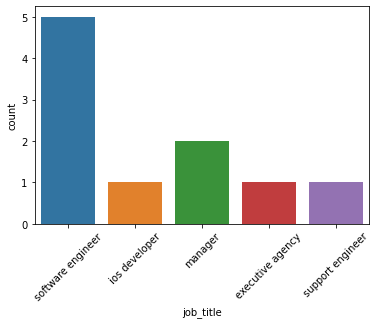

In [36]:
sns.countplot(df_final.sample(10)['job_title'])
plt.xticks(rotation=45)
plt.show()

# Data 2 -- X

In [37]:
# df2 = pd.read_csv("./Resume.csv", delimiter=",")

In [38]:
# df2.head()

# Data 3

In [39]:
df3 = pd.read_csv("./reed_uk.csv", delimiter=",")

In [40]:
df3.head()

,category,city,company_name,geo,job_board,job_description,job_requirements,job_title,job_type,post_date,salary_offered,state
0,catering jobs,Chudleigh,Haulfryn Group,uk,reed,Apply now New opportunity not to be missed! H...,NaN,Commis Chef,"Permanent, full-time",3/12/2018,"£18,323 per annum",Devon
1,law jobs,Swindon,Reed,uk,reed,Apply now This role requires an experienced s...,NaN,Corporate Legal Secretary,"Permanent, full-time",3/8/2018,"£18,000 - £22,000 per annum",Wiltshire
2,factory jobs,Norfolk,Swanstaff Recruitment Ltd,uk,reed,Apply now Job Title: Warehouse personLocation...,NaN,Warehouse Person,"Permanent, full-time",2/27/2018,Salary not specified,East Anglia
3,law jobs,Hurstpierpoint,Castles Solicitors,uk,reed,Apply now Castles Solicitors are looking for ...,Required skills Admin Case Management Corresp...,Legal Secretary / Admin Assistant,"Permanent, full-time or part-time",2/21/2018,"£15,000 - £17,000 per annum, pro-rata",West Sussex
4,factory jobs,Hertfordshire,Marketplace Group,uk,reed,Apply now International Pharmaceutical Manufa...,NaN,Category Planner - Pharmaceutical,"Permanent, full-time",3/1/2018,"£37,000 - £45,000 per annum",South East England


In [41]:
df3 = df3[['category', 'job_description', 'job_requirements', 'job_title']]

In [42]:
df3.head()

,category,job_description,job_requirements,job_title
0,catering jobs,Apply now New opportunity not to be missed! H...,NaN,Commis Chef
1,law jobs,Apply now This role requires an experienced s...,NaN,Corporate Legal Secretary
2,factory jobs,Apply now Job Title: Warehouse personLocation...,NaN,Warehouse Person
3,law jobs,Apply now Castles Solicitors are looking for ...,Required skills Admin Case Management Corresp...,Legal Secretary / Admin Assistant
4,factory jobs,Apply now International Pharmaceutical Manufa...,NaN,Category Planner - Pharmaceutical


In [43]:
df3.shape

(50000, 4)

In [44]:
df3.head()

,category,job_description,job_requirements,job_title
0,catering jobs,Apply now New opportunity not to be missed! H...,NaN,Commis Chef
1,law jobs,Apply now This role requires an experienced s...,NaN,Corporate Legal Secretary
2,factory jobs,Apply now Job Title: Warehouse personLocation...,NaN,Warehouse Person
3,law jobs,Apply now Castles Solicitors are looking for ...,Required skills Admin Case Management Corresp...,Legal Secretary / Admin Assistant
4,factory jobs,Apply now International Pharmaceutical Manufa...,NaN,Category Planner - Pharmaceutical


In [45]:
df3.category.unique()

array(['catering jobs', 'law jobs', 'factory jobs', 'retail jobs',
       'motoring automotive jobs', 'hr jobs', 'marketing jobs',
       'estate agent jobs', 'customer service jobs',
       'accountancy qualified jobs', 'health jobs', 'logistics jobs',
       'finance jobs', 'social care jobs', 'recruitment consultancy jobs',
       'construction property jobs', 'engineering jobs',
       'admin secretarial pa jobs', 'accountancy jobs', 'sales jobs',
       'it jobs', 'education jobs', 'other jobs', 'security safety jobs',
       'energy jobs', 'apprenticeships jobs', 'training jobs',
       'charity jobs', 'strategy consultancy jobs', 'banking jobs',
       'purchasing jobs', 'fmcg jobs', 'leisure tourism jobs',
       'science jobs', 'graduate training internships jobs',
       'general insurance jobs', 'media digital creative jobs'],
      dtype=object)

In [46]:
sel_df3 = ['marketing jobs', 
           'customer service jobs', 
           'accountancy qualified jobs', 
           'finance jobs', 
           'recruitment consultancy jobs', 
           'it jobs',
           'media digital creative jobs']

In [47]:
df3 = df3[df3['category'].isin(sel_df3)]
df3.reset_index(drop=True, inplace=True)

In [48]:
df3.head(10)

,category,job_description,job_requirements,job_title
0,marketing jobs,Apply on employer's website An exciting oppor...,NaN,Marketing Manager - The Ivy Collection - Head ...
1,marketing jobs,Apply now THE COMPANY: Brewster Pratap are wo...,Required skills PPC; SEO; digital marketing e...,Digital Marketing Executive
2,marketing jobs,Apply now Conference Marketing Manager - Lond...,Required skills Events International Marketin...,Conference Marketing Manager
3,marketing jobs,Apply now Our Client a National supplier of t...,NaN,Email Marketing Executive
4,marketing jobs,Apply now A leading law firm require an Event...,NaN,Events Assistant
5,marketing jobs,Apply now Digital Marketing Executive require...,NaN,Digital Marketing Executive
6,marketing jobs,Apply now One of the UKâ€™s largest and most ...,NaN,Technical SEO Manager
7,marketing jobs,Apply now Senior Comms Planning Account Manag...,NaN,Senior Comms Planning Account Manager
8,marketing jobs,Apply now Marketing Project Manager Walsall U...,Required skills Events Marketing Marketing Ca...,Marketing Project Manager
9,marketing jobs,Apply now Medical Writer - Healthcare Adverti...,Required skills he healthcare client services...,Medical Writer


In [49]:
change_cat_df3 = {
  'marketing jobs' : 'marketing', 
   'customer service jobs' : 'customer service', 
   'accountancy qualified jobs' : 'accountancy qualified', 
   'finance jobs' : 'finance', 
   'recruitment consultancy jobs' : 'recruitment consultancy', 
   'it jobs' : 'it',
   'media digital creative jobs' : 'media digital creative'
}

df3 = df3.replace({'category' : change_cat_df3})

In [50]:
df3.isna().sum()

category               0
job_description        0
job_requirements    6171
job_title              0
dtype: int64

In [51]:
df3.fillna('', inplace=True)

In [52]:
df3[df3.duplicated(keep='first')]

,category,job_description,job_requirements,job_title
89,marketing,Apply now An opportunity has become available...,Required skills Appointments Energy Marketing...,Account Manager
108,marketing,Apply now If you have an entrepreneurial spir...,,Marketing Communications Representative
137,marketing,Apply on employer's website Help us Ace our M...,,Campaign Planner - Casino & Poker
151,marketing,Apply now Marketing ExecutiveResales Team - H...,Required skills Marketing Executive,Marketing Executive - Bournemouth
163,marketing,Apply now Are you looking for an exciting opp...,,Garment Print and Marketing Assistant
...,...,...,...,...
11125,it,Apply now Front End UI / UX Developer - City ...,Required skills CSS HTML JavaScript React SAS...,Front End UI / UX Developer - London - up to Â...
11128,it,Apply now Senior Node.js Developer required w...,Required skills BDD CSS HTML SQL TDD Javascri...,Senior Node.js Developer - Ecommerce
11165,it,Apply now Overview We are seeking a .NET deve...,,Junior Developer 6222
11168,it,Apply now C# .Net Developer - 12 Month Contra...,,.Net Developer


In [53]:
df3.drop_duplicates(keep='first', inplace=True, ignore_index=True)

In [54]:
preprocess.dataframe = df3
df3 = preprocess.dataframe

In [55]:
df3.sample(10)
# 11524

,category,job_description,job_requirements,job_title
1528,customer service,apply industry leading client looking data ana...,,data analyst
4019,recruitment consultancy,apply servoca nursing care wholly owned subsid...,required skill administrative healthcare recru...,recruitment resourcer branch administrator
7876,recruitment consultancy,apply recruitment consultant angeles 000 000 b...,required skill recruitment,recruitment consultant angeles
1378,finance,apply multi award winning 10 insurance company...,,trainee financial adviser prestigious firm dip...
1662,finance,apply financial adviser work existing client b...,,financial adviser
1831,finance,apply employer website fixed term 7 monthsour ...,,customer experience manager hastings halisham ...
7617,finance,apply genuine opportunity break global financi...,required skill call centre defined benefit def...,pension correspondence assistant
7667,finance,apply looking immediate finance admin work gla...,required skill finance admin,finance administrator
9333,accountancy qualified,apply tax seniorhertfordshire 000 000our clien...,required skill accountant senior semi senior,tax senior
6661,marketing,apply ecommerce manager huntingdon experienced...,required skill ecommerce manager huntingdon,ecommerce manager


In [56]:
data3 = [
    'marketing manager',
    'digital marketing',
    'email marketing',
    'assitant',
    'manager',
    'executive agency',
    'marketing director',
    'digital communication',
    'marketing executive',
    'pitch coordinator',
    'marketing',
    'content executive',
    'product manager',
    'coordinator press',
    'marketing assistant',
    'conference producer',
    'brand manager',
    'communication assistant',
    'social executive',
    'operation manager',
    'research manager',
    'account manager',
    'planner',
    'web development',
    'online marketing',
    'producer',
    'marketing manager',
    'assitant manager',
    'operation manager',
    'product owner',
    'marketing analyst',
    'web editor',
    'research analyst',
    'data analyst',
    'product strategy',
    'marketing analyst',
    'administrator',
    'affiliate executive',
    'customer service',
    'customer care',
    'analyst',
    'digital strategist',
    'account director',
    'business analyst',
    'planner',
    'complaint handler',
    'website analyst',
    'front end developer',
    'call',
    'service',
    'brand manager',
    'tableau developer',
    'web developer',
    'analytics',
    'support specialist',
    'copywriter',
    'executive',
    'content writer',
    'repair specialist',
    'recruitment',
    'java developer',
    'php developer',
    'node developer',
    'ruby developer',
    'sql server',
    'sql developer',
    'c\+\+ developer',
    'computer vision',
    'frontend developer',
    'ios developer',
    'backend',
    'project manager',
    'devops',
    'analsyt',
    'web',
    'customer',
    'java',
    'graphic designer',
    'business development',
    'adviser',
    'financial',
    'cyber security',
    'accountant',
    'database',
    'io developer',
    'io',
    'ios',
    'etl developer',
    'et developer',
    'etl',
    'et',
    'network',
    'network developer',
    'manager',
    'customer',
    'service',
    'customer service',
    'mobile',
    'angularjs',
    'angular js',
    'executive',
    'agency',
    'executive agency',
    'management',
    'management specialist',
    'writer',
    'copywriter',
    'marketing',
    'digital marketing',
    'devops',
    'cyber',
    'security',
    'back end',
    'backend',
    'data analyst',
    'business analyst',
    'business',
    'sql',
    'machine',
    'machinelearning',
    'machine learning',
    '.net',
    'dot net',
    'dotnet',
    '. net',
    'net dev',
    'net'
]

In [57]:
for item in data3:
    i_dt = item.split()
    if len(i_dt) == 3:
        df3['job_title'] = df3['job_title'].str.replace(r".*" + i_dt[0] + ".*" + i_dt[1] + ".*" + i_dt[2] + ".*|.*" \
                                                    + i_dt[2] + ".*" + i_dt[1] + ".*" + i_dt[0] + ".*", 
                                                    ' '.join(i_dt), 
                                                    regex=True)
    if len(i_dt) == 2:
        df3['job_title'] = df3['job_title'].str.replace(r".*" + i_dt[0] + "[^\+]*" + i_dt[1] + ".*|.*" \
                                                        + i_dt[1] + "[^\+]*" + i_dt[0] + ".*", 
                                                    ' '.join(i_dt), 
                                                    regex=True)
    if len(i_dt) == 1:
        df3['job_title'] = df3['job_title'].str.replace(r".*" + i_dt[0] + ".*|.*" + i_dt[0] + ".*", 
                                                    ' '.join(i_dt), 
                                                    regex=True)

In [58]:
resolv_word3 = {'web development' : 'web developer',
               'web editor' : 'web developer',
               'affiliate executive' : 'marketing executive',
               'customer care' : 'customer service',
               '121 customer contact research development expert' : 'data analyst',
               'complaint handler' : 'customer service',
               'website analyst' : 'web developer',
               'call' : 'customer service',
               'service' : 'customer service',
               'python analyst' : 'data analyst',
               'senior analyst' : 'data analyst',
               'analyst' : 'data analyst',
               'analytics' : 'data analyst',
               'pr assitant' : 'assitant manager',
               'executive' : 'executive agency',
               'recruitment' : 'recruiter',
               'c #' : 'c# developer',
               'c # developer' : 'c# developer',
               'c # net senior developer macclesfield â 50k' : 'c# developer',
               'node j developer' : 'node js developer',
               'node' : 'node js developer',
               'sql server' : 'sql developer',
               'c\\+\\+ developer' : 'c++ developer',
               'computer vision' : 'machine learning developer',
               'frontend developer' : 'front end developer',
               'backend' : 'back end developer',
               'back end' : 'back end developer',
               'devops' : 'devops developer',
               'analsyt' : 'data analyst',
               'web' : 'web developer',
               'customer' : 'customer service',
               'java' : 'java developer',
                'medical writer' : 'content writer',
                'senior designer' : 'graphic designer',
                'data scientist senior data scientist' : 'data science',
                'housekeeping supervisor caravan' : 'supervisor',
                'digital designer incl email social medium video' : 'graphic designer',
                'designer user experience architect' : 'ux designer',
                'front developer publishing company adobe target optimizely maxymiser brighton â â' : 'front end developer',
                'content writer' : 'copywriter',
                'digital designer' : 'graphic designer',
                'junior developer' : 'web developer',
                'data scientist quant' : 'data science',
                'management accountant technology' : 'accountant',
                'senior quantitative engineer algoone capital sii' :  'software engineer',
                'senior management accountant medium' : 'management accountant',
                'senior creative designer' : 'graphic designer',
                'business development expert network finance' : 'business development',
                'financial' : 'financial assistant',
                'client servicing representative' : 'customer service',
                'management accountant harrogate' : 'accountant',
                'developer c # net core react aws' : 'back end developer',
                'c # net junior graduate developer x 2 manchester â 30k' :  'c# developer',
                'node developer' : 'node js developer',
                'front developer' : 'front end developer',
                'data scientist' : 'data science',
                'linux system engineer work home flexible working' : 'linux developer',
                'full stack developer developer software developer' : 'full stack developer',
                'data engineer mysql machine learning python' : 'machine learning developer',
                'audit account senior' : 'audit senior',
                'c # developer net altrincham' : 'c# developer',
                'ux designer developer product designer' : 'ux designer',
                'junior designer' : 'graphic designer',
                'designer' : 'graphic designer',
                'c # software developer' : 'c# developer',
                'ux researcher' : 'ux designer',
                'junior software engineer' :  'software engineer',
                'senior developer c # net' : 'c# developer',
                'senior underwriter' : 'copywriter',
                'junior underwriter' : 'copywriter',
                'underwriter mortgage experience' : 'copywriter',
                'senior user researcher contract london 6 month' : 'ux designer',
                'data analysist' : 'data analyst',
                'ui developer' : 'ui designer',
                'data scientist sql r retail' : 'data scientist',
                'visual designer' : 'graphic designer',
                'ux designer malta' : 'ux designer',
                'c # developer horley 000 000' : 'c# developer',
                'network engineer routing firewall palo alto cisco cisco asa' : 'network engineer',
                'senior front developer doe hemel hempstead' : 'front end developer',
                'back developer' : 'back end developer',
                'software developer python' : 'software developer',
                'senior software developer bolton net' : 'software developer',
                'senior developer fintech startup' : 'software developer',
                'senior front ui developer + bonus oxford' : 'front end developer',
                'software engineer weight' : 'software engineer',
                'c # developer crawley 000 000' : 'c# developer',
                'c # developer 000 000 haywards heath' : 'c# developer',
                'reactjs developer 000 000 brighton' : 'react js developer',
                'lead front developer' : 'front end developer',
                'mobile developer net c # crewe' : 'mobile developer',
                'cloud engineer azure fintech' : 'cloud engineer',
                'front developer blockchain react london basic salary 000 000' : 'front end developer',
                'mobile developer android c # 000 benefit' : 'mobile developer',
                'junior full stack developer poole' : 'full stack developer',
                'c # developer sport bracknell 45k' : 'c# developer',
                'senior c # developer complex transactional platform' : 'c# developer',
                'big data engineer python spark redshift' : 'data engineer',
                'data specialist software developer commercial python' : 'software developer',
                'cloud engineer azure specialist' : 'cloud engineer',
                'network solution architect datacentre wireless r' : 'network engineer',
                'full stack python developer' : 'python developer',
                'software engineer net' : 'software engineer',
                'network project engineer cisco security firepower' : 'network engineer',
                'network project engineer cisco wireless cisco r' : 'network engineer',
                'c # software developer poole 40k' : 'c# developer',
                'network design development engineer senior bracknell' : 'network engineer',
                'contract full stack c # farnborough' : 'c# developer',
                'data analysis insight specialist digital agency falmouth' : 'data analyst',
                'software engineer angular' : 'software engineer',
                'front designer' : 'front end developer',
                'networking consultant guildford 000+' : 'network engineer',
                'software developer c #' : 'software developer',
                'cloud support engineer' : 'cloud engineer',
                'developer c # net mvc' : 'c# developer',
                'c # developer 000 000 worthing' : 'c# developer',
                'c # software developer vs2017 2016' : 'c# developer',
                'ux lead lead designer' : 'ux designer',
                'server network engineer' : 'network engineer',
                'senior front engineer' : 'front end developer',
                'senior data scientist' : 'data science',
                'front developer bristol' : 'front end developer',
                'developer net c #': 'c# developer',
                'c # developer net altrincham' : 'c# developer',
                'ux designer developer product designer' : 'ux designer',
                'io developer' : 'ios developer',
                'io' : 'ios developer',
                'ios' : 'ios developer',
                'et developer' : 'etl developer',
               'etl' : 'etl developer',
               'et' : 'etl developer',
               'network' : 'network engineer',
               'network developer' : 'network engineer',
               'network security' : 'network engineer',
               'customer' : 'customer service',
               'service' : 'customer service',
               'mobile' : 'mobile developer',
               'angular' : 'angular js developer',
               'angular js' : 'angular js developer',
               'executive' : 'executive agency',
               'agency' : 'executive agency',
               'management' : 'management specialist',
               'writer' : 'copywriter',
               'marketing' : 'digital marketing',
               'devops' : 'devops developer',
               'cyber'  : 'cyber security',
               'security' : 'cyber security',
               'back end' : 'back end developer',
               'backend' : 'back end developer',
               'analyst' : 'data analyst',
               'business' : 'business analyst',
               'sql' : 'sql developer',
               'database' : 'database engineer',
               'machine' : 'machine learning developer',
               'machine learning' : 'machine learning developer',
               'machinelearning' : 'machine learning developer',
                '.net' : 'dotnet developer',
                'dot net' : 'dotnet developer',
                'dotnet' : 'dotnet developer',
                '. net' : 'dotnet developer',
                'net dev' : 'dotnet developer',
                '.net developer' : 'dotnet developer',
                'net' : 'dotnet developer'
              }
df3 = df3.replace({'job_title' : resolv_word3})

In [59]:
res3 = {}
for job in df3.job_title:
    if job in res3:
        res3[job] += 1
    else:
        res3[job] = 1

In [60]:
# res3

In [61]:
uniq3 = [k for k, v in res3.items() if v > 50]
len(uniq3)

17

In [62]:
r3 = 0
for item in uniq3:
    temp = df3[df3['job_title'] == item]
    r3 += len(temp)
r3

8187

In [63]:
df3 = df3[df3['job_title'].isin(uniq3)]

In [64]:
df3.shape

(8187, 4)

In [65]:
df3.head()

,category,job_description,job_requirements,job_title
0,marketing,apply employer website exciting opportunity ar...,,manager
1,marketing,apply company brewster pratap working well kno...,required skill seo digital marketing executive...,etl developer
2,marketing,apply conference marketing manager london surr...,required skill event international marketing m...,manager
3,marketing,apply client national supplier tool machinery ...,,etl developer
5,marketing,apply digital marketing executive required exp...,,etl developer


In [66]:
df3['description'] = df3.iloc[:, 1] + " " + df3.iloc[:, 2]
first_col_df3 = df3.pop('description')
df3.insert(3, 'description', first_col_df3)
df3.head()

,category,job_description,job_requirements,description,job_title
0,marketing,apply employer website exciting opportunity ar...,,apply employer website exciting opportunity ar...,manager
1,marketing,apply company brewster pratap working well kno...,required skill seo digital marketing executive...,apply company brewster pratap working well kno...,etl developer
2,marketing,apply conference marketing manager london surr...,required skill event international marketing m...,apply conference marketing manager london surr...,manager
3,marketing,apply client national supplier tool machinery ...,,apply client national supplier tool machinery ...,etl developer
5,marketing,apply digital marketing executive required exp...,,apply digital marketing executive required exp...,etl developer


In [67]:
df3[df3.duplicated(keep='first')]

,category,job_description,job_requirements,description,job_title
123,marketing,apply senior account manager creative poslocat...,required skill account manager artwork print d...,apply senior account manager creative poslocat...,manager
331,marketing,apply ecommerce digital manager premium sports...,required skill digital marketing ecommerce,apply ecommerce digital manager premium sports...,manager
485,marketing,apply talent true interest marketing global co...,,apply talent true interest marketing global co...,etl developer
838,marketing,apply reed marketing creative fantastic opport...,,apply reed marketing creative fantastic opport...,data analyst
1036,marketing,apply currently working innovative property ma...,,apply currently working innovative property ma...,manager
...,...,...,...,...,...
9349,recruitment consultancy,apply interested working one lucrative area re...,required skill recruitment recruitment sale te...,apply interested working one lucrative area re...,recruiter
9387,recruitment consultancy,apply looking challenge motivated earn commiss...,,apply looking challenge motivated earn commiss...,etl developer
9661,,apply helpdesk service desk analyst line suppo...,,apply helpdesk service desk analyst line suppo...,data analyst
10146,,apply ever heard give free breakfast every pay...,,apply ever heard give free breakfast every pay...,executive agency


In [68]:
df3.drop_duplicates(keep='first', inplace=True, ignore_index=True)

In [69]:
df3_final = df3[['description', 'job_title']].copy()
df3_final.head()

,description,job_title
0,apply employer website exciting opportunity ar...,manager
1,apply company brewster pratap working well kno...,etl developer
2,apply conference marketing manager london surr...,manager
3,apply client national supplier tool machinery ...,etl developer
4,apply digital marketing executive required exp...,etl developer


In [70]:
df3_final.shape

(8094, 2)

In [71]:
df3_final.head(5)

,description,job_title
0,apply employer website exciting opportunity ar...,manager
1,apply company brewster pratap working well kno...,etl developer
2,apply conference marketing manager london surr...,manager
3,apply client national supplier tool machinery ...,etl developer
4,apply digital marketing executive required exp...,etl developer


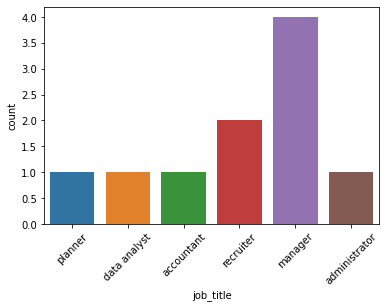

In [72]:
sns.countplot(df3_final.sample(10)['job_title'])
plt.xticks(rotation=45)
plt.show()

# Data 4

In [73]:
df4 = pd.read_csv("./sample_for_jobs.csv", delimiter=',')
df4.head(5)

,Uniq Id,Crawl Timestamp,Job Title,Job Salary,Job Experience Required,Key Skills,Role Category,Location,Functional Area,Industry,Role
0,9be62c49a0b7ebe982a4af1edaa7bc5f,2019-07-05 01:46:07 +0000,Digital Media Planner,Not Disclosed by Recruiter,5 - 10 yrs,Media Planning| Digital Media,Advertising,Mumbai,"Marketing , Advertising , MR , PR , Media Plan...","Advertising, PR, MR, Event Management",Media Planning Executive/Manager
1,3c52d436e39f596b22519da2612f6a56,2019-07-06 08:04:50 +0000,Online Bidding Executive,Not Disclosed by Recruiter,2 - 5 yrs,pre sales| closing| software knowledge| clien...,Retail Sales,"Pune,Pune","Sales , Retail , Business Development","IT-Software, Software Services",Sales Executive/Officer
2,ffad8a2396c60be2bf6d0e2ff47c58d4,2019-08-05 15:50:44 +0000,Trainee Research/ Research Executive- Hi- Tec...,Not Disclosed by Recruiter,0 - 1 yrs,Computer science| Fabrication| Quality check|...,R&D,Gurgaon,"Engineering Design , R&D","Recruitment, Staffing",R&D Executive
3,7b921f51b5c2fb862b4a5f7a54c37f75,2019-08-05 15:31:56 +0000,Technical Support,"2,00,000 - 4,00,000 PA.",0 - 5 yrs,Technical Support,Admin/Maintenance/Security/Datawarehousing,Mumbai,"IT Software - Application Programming , Mainte...","IT-Software, Software Services",Technical Support Engineer
4,2d8b7d44e138a54d5dc841163138de50,2019-07-05 02:48:29 +0000,Software Test Engineer -hyderabad,Not Disclosed by Recruiter,2 - 5 yrs,manual testing| test engineering| test cases|...,Programming & Design,Hyderabad,IT Software - QA & Testing,"IT-Software, Software Services",Testing Engineer


In [74]:
df4.shape

(30000, 11)

In [75]:
df4 = df4[['Key Skills', 'Job Title']]

In [76]:
df4[df4.duplicated(keep='first')]

,Key Skills,Job Title
168,NaN,NaN
186,NaN,NaN
212,NaN,NaN
467,NaN,NaN
476,NaN,NaN
...,...,...
29685,NaN,NaN
29710,Voice| sales| Counselling| Admissions| Counse...,Admission Support Officer(tele Counselor)
29751,Sales| marketing executive| distributors| cus...,Regional Sales Manager
29879,NaN,NaN


In [77]:
df4.drop_duplicates(keep='first', inplace=True, ignore_index=True)

In [78]:
df4.isna().sum()

Key Skills    1029
Job Title      341
dtype: int64

In [79]:
df4.head()

,Key Skills,Job Title
0,Media Planning| Digital Media,Digital Media Planner
1,pre sales| closing| software knowledge| clien...,Online Bidding Executive
2,Computer science| Fabrication| Quality check|...,Trainee Research/ Research Executive- Hi- Tec...
3,Technical Support,Technical Support
4,manual testing| test engineering| test cases|...,Software Test Engineer -hyderabad


In [80]:
df4.dropna(axis=0, inplace=True, how='any')
df4.reset_index(drop=True, inplace=True)

In [81]:
df4.head()

,Key Skills,Job Title
0,Media Planning| Digital Media,Digital Media Planner
1,pre sales| closing| software knowledge| clien...,Online Bidding Executive
2,Computer science| Fabrication| Quality check|...,Trainee Research/ Research Executive- Hi- Tec...
3,Technical Support,Technical Support
4,manual testing| test engineering| test cases|...,Software Test Engineer -hyderabad


In [82]:
df4.isna().sum()

Key Skills    0
Job Title     0
dtype: int64

In [83]:
preprocess.dataframe = df4
df4 = preprocess.dataframe

In [84]:
df4.head()

,Key Skills,Job Title
0,medium planning digital medium,digital medium planner
1,sale closing software knowledge client require...,online bidding executive
2,computer science fabrication quality check int...,trainee research research executive tech opera...
3,technical support,technical support
4,manual testing test engineering test case test...,software test engineer hyderabad


In [85]:
df4.rename(columns={'Key Skills':'description',
                    'Job Title':'job_title'}, inplace=True)

In [86]:
data4 = [
    'java developer',
    'react',
    'accountant',
    'mobile developer',
    'software developer',
    'recruiter',
    'full stack developer',
    'designer',
    'software engineer',
    'business analyst',
    'copywriter',
    'php developer',
    'ux developer',
    'io developer',
    'ruby developer',
    'devops',
    'cloud engineer',
    'data scientist',
    'data science',
    'python developer',
    'android',
    'php',
    'ruby',
    'cyber security',
    'cloud developer',
    'cloud',
    'data analyst',
    'web developer',
    'back developer',
    'analyst',
    'front developer',
    'data engineer',
    'java'
    'database',
    'business developer',
    'business',
    'customer service',
    'dotnet developer',
    'full stack',
    'content writer',
    'azure developer',
    'software architect',
    'web engineer',
    'web',
    'mobile',
    'python',
    'azure',
    'analytics',
    'net developer',
    'angular',
    'django',
    'cyber',
    'cyber specialist',
    'analysis',
    'database',
    'io developer',
    'io',
    'ios',
    'etl developer',
    'et developer',
    'etl',
    'et',
    'network',
    'network developer',
    'manager',
    'customer',
    'service',
    'customer service',
    'mobile',
    'angularjs',
    'angular js',
    'executive',
    'agency',
    'executive agency',
    'management',
    'management specialist',
    'writer',
    'copywriter',
    'marketing',
    'digital marketing',
    'devops',
    'cyber',
    'security',
    'back end',
    'backend',
    'data analyst',
    'business analyst',
    'business',
    'sql',
    'machine',
    'machinelearning',
    'machine learning',
    '.net',
    'dot net',
    'dotnet',
    '. net',
    'net dev',
    'net'
]

In [87]:
for item in data4:
    i_dt = item.split()
    if len(i_dt) == 3:
        df4['job_title'] = df4['job_title'].str.replace(r".*" + i_dt[0] + ".*" + i_dt[1] + ".*" + i_dt[2] + ".*|.*" 
                                                        + i_dt[2] + ".*" + i_dt[1] + ".*" + i_dt[0] + ".*", 
                                                    ' '.join(i_dt), 
                                                    regex=True)
    if len(i_dt) == 2:
        df4['job_title'] = df4['job_title'].str.replace(r".*" + i_dt[0] + "[^\+]*" + i_dt[1] + ".*|.*" 
                                                        + i_dt[1] + "[^\+]*" + i_dt[0] + ".*", 
                                                    ' '.join(i_dt), 
                                                    regex=True)
    if len(i_dt) == 1:
        df4['job_title'] = df4['job_title'].str.replace(r".*" + i_dt[0] + ".*|.*" + i_dt[0] + ".*", 
                                                    ' '.join(i_dt), 
                                                    regex=True)

In [88]:
resolv_word4 = {'react':'react js developer',
                'react developer' : 'react js developer',
                'reactjs developer' : 'react js developer',
                'designer' : 'graphic designer',
                'ux developer' : 'ux designer',
                'io developer' : 'ios developer',
                'delv senior software eng' : 'software engineer',
                'software engineer java' : 'software engineer',
                'software engineer 2' : 'software engineer',
                'network administrator' : 'network engineer',
                'back developer' : 'back end developer',
                'delv software engineer' : 'software engineer',
                'c # developer' : 'c# developer',
                'software engineer ii' : 'software engineer',
                'node developer' : 'node js developer',
                'java technical lead' : 'java developer',
                'frontend developer' : 'front end developer',
                'linux administrator' : 'linux developer',
                'software engineer android' : 'software engineer',
                'programmer analyst' : 'data analyst',
                'security analyst' : 'cyber security',
                'ui developer' : 'ui designer',
                'java enterprise edition' : 'java developer',
                'developer c #' : 'c# developer',
                'devops' : 'devops developer',
                'data scientist' : 'data science',
                'angularjs developer' : 'angular js developer',
                'senior front developer' : 'front end developer',
                'python scripting' : 'python developer',
                'android lead' : 'android developer',
                'android' : 'android developer',
                'java architect' : 'java developer',
                'php' : 'php developer',
                'ruby' : 'ruby developer',
                'java programmer' : 'java developer',
                'front engineer' : 'front end developer',
                'c c++ developer' : 'c developer',
                'java scala dev' : 'java developer',
                'nodejs developer' : 'node js developer',
                'c # dot developer' : 'c# developer',
                'cloud developer' : 'cloud engineer',
                'cloud' : 'cloud engineer',
                'analytics' : 'data analyst',
                'core java multithreading' : 'java developer',
                'vc++ developer' : 'c++ developer',
                'back developer' : 'back end developer',
                'analyst' : 'data analyst',
                'front developer' : 'front end developer',
                'java' : 'java developer',
                'net c # looking immediate day np' : 'c# developer',
                'database'  : 'database engineer',
                'business developer' : 'business analyst',
                'business' : 'business analyst',
                'data developer' : 'data engineer',
                'senior software engg system' : 'software engineer',
                'backend engineer' : 'back end engineer',
                'html developer' : 'front end developer',
                'net' : 'dotnet developer',
                'c # asp vb mvc developer' : 'c# developer',
                'architect pl c++ vtk' : 'c++ developer',
                'urgent opening java full stack bangalore' : 'java developer',
                'python programming faculty' : 'python developer',
                'c # dev' : 'c# developer',
                'full stack ui technical lead' : 'full stack developer',
                'full stack' : 'full stack developer',
                'mean stack developer node express j' : 'full stack developer',
                'content writer' : 'copywriter',
                'c # jenkins developer contract hire' : 'c# developer',
                'software artchitect c++ 17 design development r' : 'c# developer',
                'net jquery ajax c # okhla phase 3 salary 20k' : 'back end developer',
                'power ux development expert data visualization dashboard design' : 'ux designer',
                'web engineer' : 'web developer',
                'web' : 'web developer',
                'mobile' : 'mobile developer',
                'python + scrapy' : 'python developer',
                'python' : 'python developer',
                'net developer c # restful api' : 'back end developer',
                'azure' : 'azure developer',
                'analytics' : 'data analyst',
                'system engineer c++ qt' : 'c++ developer',
                'net developer' : 'dotnet developer',
                'angular' : 'angular js developer',
                'django' : 'back end developer',
                'cyber' : 'cyber security',
                'cyber specialist' : 'cyber security',
                'analysis' : 'data analyst',
                'sql' : 'sql developer',
                'c++' : 'c++ developer',
                'java standard edition' : 'java developer',
                'engineer selenium c #' : 'back end developer',
                'lead c + + developer' : 'c++ developer',
                'module lead java kafka hibernate 5 8 year' : 'back end developer',
                'io' : 'ios developer',
                'io developer' : 'ios developer', 
               'ios' : 'ios developer',
               'et developer' : 'etl developer',
                'et developer' : 'etl developer',
               'etl' : 'etl developer',
               'et' : 'etl developer',
               'network' : 'network engineer',
               'network developer' : 'network engineer',
               'network security' : 'network engineer',
               'customer' : 'customer service',
               'service' : 'customer service',
               'mobile' : 'mobile developer',
               'angular' : 'angular js developer',
               'angular js' : 'angular js developer',
               'executive' : 'executive agency',
               'agency' : 'executive agency',
               'management' : 'management specialist',
               'writer' : 'copywriter',
               'marketing' : 'digital marketing',
               'devops' : 'devops developer',
               'cyber'  : 'cyber security',
               'security' : 'cyber security',
               'back end' : 'back end developer',
               'backend' : 'back end developer',
               'analyst' : 'data analyst',
               'business' : 'business analyst',
               'sql' : 'sql developer',
               'database' : 'database engineer',
               'machine' : 'machine learning developer',
               'machine learning' : 'machine learning developer',
               'machinelearning' : 'machine learning developer',
                '.net' : 'dotnet developer',
                'dot net' : 'dotnet developer',
                'dotnet' : 'dotnet developer',
                '. net' : 'dotnet developer',
                'net dev' : 'dotnet developer',
                '.net developer' : 'dotnet developer',
                'net' : 'dotnet developer'
              }
df4 = df4.replace({'job_title' : resolv_word4})

In [89]:
res4 = {}
for job in df4.job_title:
    if job in res4:
        res4[job] += 1
    else:
        res4[job] = 1

In [90]:
# res4

In [91]:
uniq4 = [k for k, v in res4.items() if v > 30]
len(uniq4)

37

In [92]:
r4 = 0
for item in uniq4:
    temp = df4[df4['job_title'] == item]
    r4 += len(temp)
r4

19361

In [93]:
df4 = df4[df4['job_title'].isin(uniq4)]

In [94]:
df4.shape

(19361, 2)

In [95]:
df4.head()

,description,job_title
1,sale closing software knowledge client require...,executive agency
2,computer science fabrication quality check int...,ios developer
4,manual testing test engineering test case test...,software engineer
5,adobe experience manager digital digital marke...,data analyst
7,azure vsts docker dynatrace splunk aws,devops developer


In [96]:
df4[df4.duplicated(keep='first')]

,description,job_title
581,teaching educator counselor mentor trainer adv...,management specialist
646,teaching educator counselor mentor trainer adv...,etl developer
749,marketing executive distributor customer profi...,etl developer
817,c++ c design mysql javascript html,ios developer
850,help desk customer service customer relationsh...,ios developer
...,...,...
27973,international sale expedia international first...,ios developer
28044,talent acquisition,ios developer
28086,company secretary assistant company secretary,etl developer
28127,sap abap smartforms abap object adobe form enh...,ios developer


In [97]:
df4.drop_duplicates(keep='first', inplace=True, ignore_index=True)

In [98]:
df4_final = df4.copy()

In [99]:
df4_final['job_title'].value_counts()

ios developer            5247
manager                  2392
etl developer            1557
executive agency         1505
business analyst         1028
data analyst              936
software engineer         765
java developer            626
customer service          600
graphic designer          566
recruiter                 355
developer                 354
copywriter                248
accountant                221
software developer        197
full stack developer      184
android developer         161
management specialist     153
devops developer          145
cloud engineer            134
mobile developer          129
python developer          122
web developer             117
react js developer        110
cyber security             97
data science               95
front end developer        91
back end developer         85
data engineer              81
angular js developer       77
sql developer              76
database engineer          65
engineer                   61
php develo

In [100]:
df4_final.shape

(18734, 2)

In [101]:
df4_final.head(5)

,description,job_title
0,sale closing software knowledge client require...,executive agency
1,computer science fabrication quality check int...,ios developer
2,manual testing test engineering test case test...,software engineer
3,adobe experience manager digital digital marke...,data analyst
4,azure vsts docker dynatrace splunk aws,devops developer


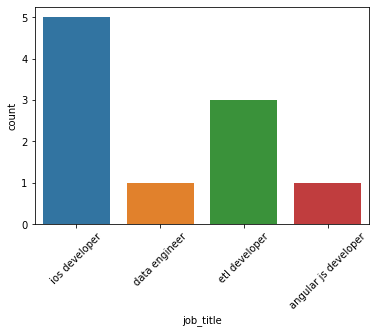

In [102]:
sns.countplot(df4_final.sample(10)['job_title'])
plt.xticks(rotation=45)
plt.show()

# Data 5

In [103]:
df5 = pd.read_csv('./resume_dataset_it.csv', delimiter=',')
df5.head(5)

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [104]:
df5.isna().sum()

Category    0
Resume      0
dtype: int64

In [105]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  169 non-null    object
 1   Resume    169 non-null    object
dtypes: object(2)
memory usage: 2.8+ KB


In [106]:
preprocess.dataframe = df5
df5 = preprocess.dataframe

In [107]:
df5.head()

,Category,Resume
0,data science,skill programming language python panda numpy ...
1,data science,education detail 2013 may 2017 b e rgpvdata sc...
2,data science,area interest deep learning control system des...
3,data science,skill r python hana tableau hana hana sql lumi...
4,data science,education detail ymcaust faridabad haryanadata...


In [108]:
df5.rename(columns={'Category':'job_title', 
                    'Resume': 'description'}, inplace=True)

In [109]:
df5.head()

,job_title,description
0,data science,skill programming language python panda numpy ...
1,data science,education detail 2013 may 2017 b e rgpvdata sc...
2,data science,area interest deep learning control system des...
3,data science,skill r python hana tableau hana hana sql lumi...
4,data science,education detail ymcaust faridabad haryanadata...


In [110]:
first_col_df5 = df5.pop('description')
df5.insert(0, 'description', first_col_df5)
df5.head()

,description,job_title
0,skill programming language python panda numpy ...,data science
1,education detail 2013 may 2017 b e rgpvdata sc...,data science
2,area interest deep learning control system des...,data science
3,skill r python hana tableau hana hana sql lumi...,data science
4,education detail ymcaust faridabad haryanadata...,data science


In [111]:
select_job_df5 = ['data science', 
                  'web designing' ,
                  'java developer', 
                  'business analyst', 
                  'python developer', 
                  'devops engineer', 
                  'network security engineer', 
                  'database',
                  'dotnet developer',
                  'etl developer']

In [112]:
df5 = df5[df5['job_title'].isin(select_job_df5)]

In [113]:
resolv_word5 = {'web designing':'web developer',
                'network security engineer' : 'network engineer',
                'database' : 'database engineer'
              }
df5 = df5.replace({'job_title' : resolv_word5})

In [114]:
df5.head()

,description,job_title
0,skill programming language python panda numpy ...,data science
1,education detail 2013 may 2017 b e rgpvdata sc...,data science
2,area interest deep learning control system des...,data science
3,skill r python hana tableau hana hana sql lumi...,data science
4,education detail ymcaust faridabad haryanadata...,data science


In [115]:
df5[df5.duplicated(keep='first')]

,description,job_title
39,technical skill technology angular html5 css3 ...,web developer
71,technicalskills springmvc hibernate jdbc java ...,java developer


In [116]:
df5.drop_duplicates(keep='first', inplace=True, ignore_index=True)

In [117]:
df5_final = df5.copy()

In [118]:
df5_final.shape

(74, 2)

In [119]:
df5_final.job_title.unique()

array(['data science', 'web developer', 'java developer',
       'business analyst', 'python developer', 'devops engineer',
       'network engineer', 'database engineer', 'etl developer',
       'dotnet developer'], dtype=object)

In [120]:
df5_final['job_title'].value_counts()

java developer       13
database engineer    11
data science         10
devops engineer       7
dotnet developer      7
business analyst      6
python developer      6
network engineer      5
etl developer         5
web developer         4
Name: job_title, dtype: int64

In [121]:
df5_final.head(5)

,description,job_title
0,skill programming language python panda numpy ...,data science
1,education detail 2013 may 2017 b e rgpvdata sc...,data science
2,area interest deep learning control system des...,data science
3,skill r python hana tableau hana hana sql lumi...,data science
4,education detail ymcaust faridabad haryanadata...,data science


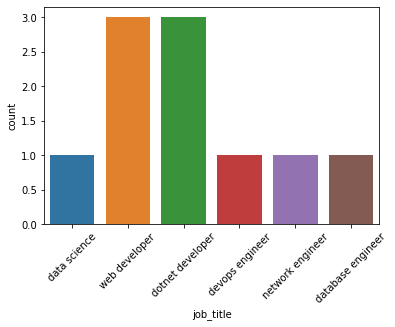

In [122]:
sns.countplot(df5_final.sample(10)['job_title'])
plt.xticks(rotation=45)
plt.show()

*Join All DataFrame*

In [123]:
# Process Join 
data_df = {'description' : [],
            'job_title' : []}

proc_df = [df_final, df3_final, df4_final, df5_final]
for dataframe in proc_df:
    data_df['description'] += dataframe['description'].tolist()
    data_df['job_title'] += dataframe['job_title'].tolist()

In [124]:
df_all = pd.DataFrame(data=data_df, columns=['description', 'job_title'])

In [125]:
preprocess.dataframe = df_all
df_all = preprocess.dataframe

In [126]:
df_all.drop_duplicates(keep='first', inplace=True, ignore_index=True)

In [127]:
resolv_word_all = {
                'io developer' : 'ios developer',
                'front developer' : 'front end developer',
                'service' : 'customer service',
                'react developer' : 'react js developer',
                'adviser' : 'advisor',
                'specialist' : 'management specialist',
                'back developer' : 'back end developer',
                'dot developer' : 'dotnet developer',
                'net developer' : 'dotnet developer',
                'angular developer' : 'angular js developer',
                'sale manager' : 'sales manager',
                'sale executive' : 'sales executive',
                'executive' : 'sales executive',
                'sale engineer' : 'sales engineer',
                'digital marketing executive' : 'digital marketing',
                'executive' : 'executive agency',
                'area sale manager' : 'sales manager',
                'marketing' : 'digital marketing',
                'devops engineer' : 'devops developer',
                'project management' : 'project manager',
                'security engineer' : 'cyber security',
                'marketing executive' : 'digital marketing',
                'etl developer' : 'database engineer',
                'data engineer' : 'database engineer'
              }
df_all = df_all.replace({'job_title' : resolv_word_all})

In [128]:
del_labels = ['developer', 
              'sales executive', 
              'sales executive', 
              'qa engineer', 
              'engineer',
              'associate',
              'account executive',
              'sales engineer', 
              'platform engineer',
              'hiring',
              'planner',
              'advisor',
              'administrator'
              'management specialist',
              'account executive',
              'salesforce developer',
              'manager',
              'technology architect',
              'associate manager',
              'support engineer',
              'financial assistant',
              'program manager',
              'account manager',
              'quality assurance',
              'sales manager',
              'analyst finance',
              'manager finance',
              'engineering',
              'copywriter',
              'analyst finance',
              'assistant manager',
              'network engineer', 
              'business development',
              'recruiter',
              'executive agency',
              'graphic designer',
              'accoutant',
              'accountant', 
              'consultant',
              'management specialist',
              'research analyst',
              'angular js developer',
              'cloud engineer',
              'back end developer',
              'azure engineer',
              'project manager',
              'product manager',
              'azure developer',
              'customer service',
              'dotnet developer'
              ]

In [129]:
df_all = df_all[~(df_all['job_title'].isin(del_labels))]
df_all = df_all[~(df_all['description'] == '')]

In [130]:
df_all = shuffle(df_all)
df_all.dropna(inplace=True)
df_all.drop_duplicates(inplace=True, ignore_index=True)
df_all.reset_index(drop=True, inplace=True)

In [131]:
df_all.head(5)

,description,job_title
0,scripting language like python shell scripting...,software engineer
1,must minimum 3 year relevant hand experience c...,software engineer
2,6+ year hand design configuration experience f...,software engineer
3,responsibility 2+ year professional software d...,software engineer
4,financial market excel banking operation focus...,ios developer


In [132]:
df_all.isna().sum()

description    0
job_title      0
dtype: int64

In [133]:
df_all.to_csv("data.csv", sep=',', index=False)

# =========================================

In [134]:
def chg_whitespace(texts):
    texts = re.sub('\s+', '', texts)
    
    return texts

In [135]:
label_encode_decode = {chg_whitespace(label) : label for label in df_all['job_title'].unique()}

In [136]:
label_encode_decode

{'softwareengineer': 'software engineer',
 'iosdeveloper': 'ios developer',
 'androiddeveloper': 'android developer',
 'javadeveloper': 'java developer',
 'databaseengineer': 'database engineer',
 'datascience': 'data science',
 'webdeveloper': 'web developer',
 'sqldeveloper': 'sql developer',
 'mobiledeveloper': 'mobile developer',
 'phpdeveloper': 'php developer',
 'businessanalyst': 'business analyst',
 'devopsdeveloper': 'devops developer',
 'systemengineer': 'system engineer',
 'dataanalyst': 'data analyst',
 'cybersecurity': 'cyber security',
 'administrator': 'administrator',
 'machinelearningdeveloper': 'machine learning developer',
 'frontenddeveloper': 'front end developer',
 'pythondeveloper': 'python developer',
 'reactjsdeveloper': 'react js developer',
 'softwaredeveloper': 'software developer',
 'fullstackdeveloper': 'full stack developer'}

In [137]:
df_percob1 = df_all.copy()

In [138]:
df_percob1.iloc[:, 1] = list(map(lambda x : chg_whitespace(x), df_percob1.iloc[:, 1]))

In [139]:
df_percob1.shape

(32600, 2)

In [140]:
df_percob1['job_title'].unique()

array(['softwareengineer', 'iosdeveloper', 'androiddeveloper',
       'javadeveloper', 'databaseengineer', 'datascience', 'webdeveloper',
       'sqldeveloper', 'mobiledeveloper', 'phpdeveloper',
       'businessanalyst', 'devopsdeveloper', 'systemengineer',
       'dataanalyst', 'cybersecurity', 'administrator',
       'machinelearningdeveloper', 'frontenddeveloper', 'pythondeveloper',
       'reactjsdeveloper', 'softwaredeveloper', 'fullstackdeveloper'],
      dtype=object)

In [141]:
df_percob1['job_title'].nunique()

22

In [142]:
df_percob1['job_title'].value_counts()

iosdeveloper                9435
softwareengineer            9147
databaseengineer            4353
dataanalyst                 2129
businessanalyst             1936
javadeveloper               1045
datascience                  786
devopsdeveloper              605
administrator                377
fullstackdeveloper           359
systemengineer               321
androiddeveloper             271
cybersecurity                265
pythondeveloper              227
softwaredeveloper            197
webdeveloper                 194
reactjsdeveloper             184
mobiledeveloper              165
frontenddeveloper            164
machinelearningdeveloper     157
phpdeveloper                 147
sqldeveloper                 136
Name: job_title, dtype: int64

### == SOLVE IMBALANCED DATA ==

In [143]:
see_labels = {}
for idx, val in zip(df_all['job_title'].value_counts().index.tolist(),
                    df_all['job_title'].value_counts().tolist()):
    see_labels[idx] = val

In [144]:
data_must_added = {k:v for k, v in see_labels.items() if v < 2500}
data_must_added

{'data analyst': 2129,
 'business analyst': 1936,
 'java developer': 1045,
 'data science': 786,
 'devops developer': 605,
 'administrator': 377,
 'full stack developer': 359,
 'system engineer': 321,
 'android developer': 271,
 'cyber security': 265,
 'python developer': 227,
 'software developer': 197,
 'web developer': 194,
 'react js developer': 184,
 'mobile developer': 165,
 'front end developer': 164,
 'machine learning developer': 157,
 'php developer': 147,
 'sql developer': 136}

In [145]:
data1 = {k:len(df_final[df_final['job_title'] == k]) for k in data_must_added.keys()}
data3 = {k:len(df3_final[df3_final['job_title'] == k]) for k in data_must_added.keys()}
data4 = {k:len(df4_final[df4_final['job_title'] == k]) for k in data_must_added.keys()}
data5 = {k:len(df5_final[df5_final['job_title'] == k]) for k in data_must_added.keys()}

In [146]:
data1

{'data analyst': 655,
 'business analyst': 813,
 'java developer': 301,
 'data science': 681,
 'devops developer': 453,
 'administrator': 0,
 'full stack developer': 175,
 'system engineer': 322,
 'android developer': 110,
 'cyber security': 168,
 'python developer': 99,
 'software developer': 0,
 'web developer': 0,
 'react js developer': 0,
 'mobile developer': 36,
 'front end developer': 73,
 'machine learning developer': 157,
 'php developer': 100,
 'sql developer': 60}

In [147]:
df_all_v2 = df_all.copy()
df_all_v2.shape

(32600, 2)

In [148]:
max_len = 0
for x in df_all_v2['description']:
    if len(x.split()) > max_len:
        max_len = len(x.split())

In [149]:
max_len

997

In [150]:
for k in data1.keys():
    df_all_v2 = pd.concat(objs=[df_all_v2, df_final[df_final['job_title'] == k]])
for k in data3.keys():
    df_all_v2 = pd.concat(objs=[df_all_v2, df3_final[df3_final['job_title'] == k]])
for k in data4.keys():
    df_all_v2 = pd.concat(objs=[df_all_v2, df4_final[df4_final['job_title'] == k]])
for k in data5.keys():
    df_all_v2 = pd.concat(objs=[df_all_v2, df5_final[df5_final['job_title'] == k]])

In [151]:
df_all_v2.shape

(42190, 2)

In [152]:
df_all_v2.isna().sum()

description    0
job_title      0
dtype: int64

In [153]:
df_all_v2 = df_all_v2[~(df_all_v2['description'] == '')].reset_index(drop=True)

In [154]:
df_all_v2['job_title'].value_counts()

ios developer                 9435
software engineer             9147
database engineer             4353
data analyst                  4258
business analyst              3873
java developer                2091
data science                  1572
devops developer              1203
administrator                  755
full stack developer           718
system engineer                643
android developer              542
cyber security                 530
python developer               454
software developer             394
web developer                  389
mobile developer               330
front end developer            328
machine learning developer     314
php developer                  294
react js developer             294
sql developer                  272
Name: job_title, dtype: int64

In [155]:
df_all_v2.shape

(42189, 2)

In [156]:
NUM_MAX = 1800

In [157]:
# ios developer
temp_del_ios_dev = df_all_v2[df_all_v2['job_title'] == 'ios developer'].reset_index(drop=True).copy()
select_ios_dev = shuffle(temp_del_ios_dev)[:NUM_MAX]
temp_del_ios_dev = select_ios_dev.reset_index(drop=True)

In [158]:
# software engineer
temp_del_soft_eng = df_all_v2[df_all_v2['job_title'] == 'software engineer'].reset_index(drop=True).copy()
select_soft_eng = shuffle(temp_del_soft_eng)[:NUM_MAX]
temp_del_soft_eng = select_soft_eng.reset_index(drop=True)

In [159]:
# data analyst
temp_del_data_analyst = df_all_v2[df_all_v2['job_title'] == 'data analyst'].reset_index(drop=True).copy()
select_data_analyst = shuffle(temp_del_data_analyst)[:NUM_MAX]
temp_del_data_analyst = select_data_analyst.reset_index(drop=True)

In [160]:
# business analyst
temp_del_busines_analyst = df_all_v2[df_all_v2['job_title'] == 'business analyst'].reset_index(drop=True).copy()
select_busines_analyst = shuffle(temp_del_busines_analyst)[:NUM_MAX]
temp_del_busines_analyst = select_busines_analyst.reset_index(drop=True)

In [161]:
# database engineer
temp_del_data_eng = df_all_v2[df_all_v2['job_title'] == 'database engineer'].reset_index(drop=True).copy()
select_data_eng = shuffle(temp_del_data_eng)[:NUM_MAX]
temp_del_data_eng = select_data_eng.reset_index(drop=True)

In [162]:
# java developer
temp_del_jav_dev = df_all_v2[df_all_v2['job_title'] == 'java developer'].reset_index(drop=True).copy()
select_jav_dev = shuffle(temp_del_jav_dev)[:NUM_MAX]
temp_del_jav_dev = select_jav_dev.reset_index(drop=True)

In [163]:
df_all_v2 = df_all_v2[~(df_all_v2['job_title'] == 'ios developer')]
df_all_v2 = df_all_v2[~(df_all_v2['job_title'] == 'software engineer')]
df_all_v2 = df_all_v2[~(df_all_v2['job_title'] == 'data analyst')]
df_all_v2 = df_all_v2[~(df_all_v2['job_title'] == 'business analyst')]
df_all_v2 = df_all_v2[~(df_all_v2['job_title'] == 'database engineer')]
df_all_v2 = df_all_v2[~(df_all_v2['job_title'] == 'java developer')]

In [164]:
df_all_v2['job_title'].value_counts()

data science                  1572
devops developer              1203
administrator                  755
full stack developer           718
system engineer                643
android developer              542
cyber security                 530
python developer               454
software developer             394
web developer                  389
mobile developer               330
front end developer            328
machine learning developer     314
php developer                  294
react js developer             294
sql developer                  272
Name: job_title, dtype: int64

In [165]:
df_all_v2 = pd.concat([df_all_v2, 
                         temp_del_ios_dev, 
                         temp_del_soft_eng, 
                         temp_del_data_analyst, 
                         temp_del_busines_analyst,
                         temp_del_data_eng,
                         temp_del_jav_dev
                        ])
df_all_v2 = shuffle(df_all_v2)
df_all_v2.reset_index(drop=True, inplace=True)

In [166]:
df_all_v2.head(5)

,description,job_title
0,responsibility looking experienced software en...,software engineer
1,senior developer 6+ year experience analysis d...,software engineer
2,solution architecture team required translate ...,ios developer
3,qualification graduate btech caexperience requ...,android developer
4,analytical technical support training time man...,data analyst


In [167]:
df_all_v2.shape

(19832, 2)

In [168]:
df_all_v2['job_title'].value_counts()

software engineer             1800
database engineer             1800
data analyst                  1800
business analyst              1800
ios developer                 1800
java developer                1800
data science                  1572
devops developer              1203
administrator                  755
full stack developer           718
system engineer                643
android developer              542
cyber security                 530
python developer               454
software developer             394
web developer                  389
mobile developer               330
front end developer            328
machine learning developer     314
php developer                  294
react js developer             294
sql developer                  272
Name: job_title, dtype: int64

In [169]:
df_all_v2.to_csv("datav2.csv", sep=',', index=False)